In [ ]:
# ETL_healthcare.py
# -------------------------------
# Data Engineer Task: Build ETL pipeline for patient-doctor-feedback data
# -------------------------------

import pandas as pd
import os

# Ensure warehouse directory exists
os.makedirs("data_warehouse", exist_ok=True)

# 1. Ingestion
patients_df = pd.read_csv("patients_data_with_doctor.csv")
doctors_df = pd.read_csv("doctors_info.csv")
feedback_df = pd.read_json("patient_feedback.json")

# 2. Cleansing
# Convert costs to numeric
patients_df['treatment_cost'] = patients_df['treatment_cost'].replace('[\$,]', '', regex=True).astype(float)
patients_df['room_cost'] = patients_df['room_cost'].replace('[\$,]', '', regex=True).astype(float)

# Standardize date columns
patients_df['treatment_date'] = pd.to_datetime(patients_df['treatment_date'], errors='coerce')
feedback_df['review_date'] = pd.to_datetime(feedback_df['review_date'], errors='coerce')

# 3. Transformation
# Total cost per treatment (treatment + room)
patients_df['total_cost'] = patients_df['treatment_cost'] + patients_df['room_cost']

# Keep latest feedback per patient-treatment pair
feedback_df = feedback_df.sort_values('review_date').drop_duplicates(
    subset=['patient_id', 'treatment_id'], keep='last'
)

# Merge datasets
merged_df = pd.merge(patients_df, doctors_df, on='doctor_id', how='left')
merged_df = pd.merge(merged_df, feedback_df, on=['patient_id', 'treatment_id'], how='left')

# Remove invalid rows (only cost > 0 required)
merged_df = merged_df[merged_df['total_cost'] > 0]

# 4. Loading
output_path = "data_warehouse/processed_patient_data.csv"
merged_df.to_csv(output_path, index=False)

print(f"Processed data saved to {output_path}")


Processed data saved to data_warehouse/processed_patient_data.csv


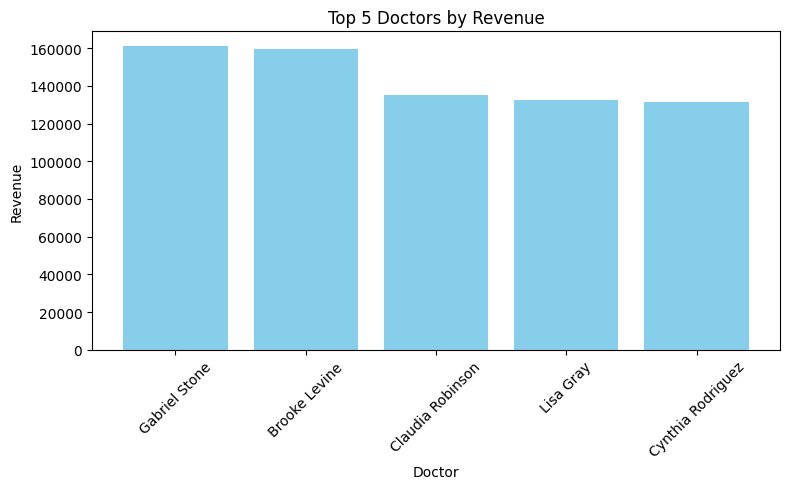


--- Top 5 Doctors by Revenue & Feedback ---
  doctor_id        doctor_name  total_cost  patient_feedback_score
0      D039      Gabriel Stone   160905.05                     NaN
1      D042      Brooke Levine   159369.34                     NaN
2      D018   Claudia Robinson   134953.36                     NaN
3      D040          Lisa Gray   132596.89                     NaN
4      D012  Cynthia Rodriguez   131264.42                     NaN


In [ ]:
# DA_healthcare.py
# -------------------------------
# Data Analyst Task: Find top 5 doctors by revenue & analyze patient feedback
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# 1. Load processed data
df = pd.read_csv("data_warehouse/processed_patient_data.csv")

# 2. Find top 5 doctors by revenue
doctor_revenue = df.groupby(['doctor_id', 'doctor_name'])['total_cost'].sum().reset_index()
top5_doctors = doctor_revenue.sort_values(by='total_cost', ascending=False).head(5)

# 3. Merge with average patient feedback
doctor_feedback = df.groupby(['doctor_id', 'doctor_name'])['patient_feedback_score'].mean().reset_index()
top5 = pd.merge(top5_doctors, doctor_feedback, on=['doctor_id', 'doctor_name'], how='left')

# 4. Visualization: Revenue
plt.figure(figsize=(8,5))
plt.bar(top5['doctor_name'], top5['total_cost'], color='skyblue')
plt.xlabel("Doctor")
plt.ylabel("Revenue")
plt.title("Top 5 Doctors by Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n--- Top 5 Doctors by Revenue & Feedback ---")
print(top5)

In [ ]:
# ML_VIP_healthcare.py
# -------------------------------
# ML Engineer Task: Classify VIP Patients & Reverse ETL
# -------------------------------

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

# Ensure warehouse directory exists
os.makedirs("data_warehouse", exist_ok=True)

# 1. Load processed patient data
df = pd.read_csv("data_warehouse/processed_patient_data.csv")

# 2. Feature engineering (patient-level)
patient_df = df.groupby('patient_id').agg(
    total_cost=('total_cost', 'sum'),
    visit_frequency=('treatment_id', 'count')
).reset_index()

# Average treatment cost per patient
patient_df['avg_treatment_cost'] = patient_df['total_cost'] / patient_df['visit_frequency']
patient_df = patient_df.fillna(0)

# Prevent empty data issue
if patient_df.empty:
    raise ValueError("No patient data available for clustering. Check ETL filtering.")

# 3. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(patient_df[['total_cost', 'visit_frequency', 'avg_treatment_cost']])

# 4. K-Means clustering (k=2)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
patient_df['cluster'] = kmeans.fit_predict(X_scaled)

# Assign VIP = 1 (cluster with highest spend), Non-VIP = 0
vip_cluster = patient_df.groupby('cluster')['total_cost'].mean().idxmax()
patient_df['VIP_Status'] = 0
patient_df.loc[patient_df['cluster'] == vip_cluster, 'VIP_Status'] = 1

# 5. Reverse ETL: merge VIP info back to full dataset
df = pd.merge(df, patient_df[['patient_id', 'VIP_Status']], on='patient_id', how='left')

# 6. Save enriched dataset
output_path = "data_warehouse/patients_with_vip.csv"
df.to_csv(output_path, index=False)

print(f"VIP classification complete. File saved to {output_path}")
print(patient_df[['patient_id', 'VIP_Status']].head())

VIP classification complete. File saved to data_warehouse/patients_with_vip.csv
  patient_id  VIP_Status
0      P0001           0
1      P0002           1
2      P0006           0
3      P0007           0
4      P0009           0
